In [ ]:
#importing all libraries to use for analysis
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as scaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


# **1.Loading Dataset**

In [ ]:
austin_data = pd.read_csv('/content/drive/My Drive/austinHousingData.csv')


In [ ]:
#checking datatypes of all columns
print(austin_data.dtypes)

zpid                            int64
city                           object
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
numPriceChanges                 int64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
latestPriceSource              object
numOfPhotos                     int64
numOfAccessibilityFeatures      int64
numOfApplian

everything is in correct data format

In [ ]:
#check and print nulls per column to see if there are nulls
null_counts = austin_data.isnull().sum()
print(null_counts)


zpid                          0
city                          0
streetAddress                 0
zipcode                       0
description                   0
latitude                      0
longitude                     0
propertyTaxRate               0
garageSpaces                  0
hasAssociation                0
hasCooling                    0
hasGarage                     0
hasHeating                    0
hasSpa                        0
hasView                       0
homeType                      0
parkingSpaces                 0
yearBuilt                     0
latestPrice                   0
numPriceChanges               0
latest_saledate               0
latest_salemonth              0
latest_saleyear               0
latestPriceSource             0
numOfPhotos                   0
numOfAccessibilityFeatures    0
numOfAppliances               0
numOfParkingFeatures          0
numOfPatioAndPorchFeatures    0
numOfSecurityFeatures         0
numOfWaterfrontFeatures       0
numOfWin

data contains no null values

# **2. Basic EDA**

Conduct basic exploratory data analysis to get a better understanding of the variables in the dataset


In [ ]:
# selecting only numeric features of the dataset, as these are only variables that can be used for clustering
numeric_columns = [
    'zipcode', 'latitude', 'longitude', 'propertyTaxRate', 'garageSpaces', 'parkingSpaces',
    'yearBuilt', 'latestPrice', 'numPriceChanges', 'lotSizeSqFt', 'livingAreaSqFt',
    'avgSchoolDistance', 'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
    'numOfBathrooms', 'numOfBedrooms', 'numOfStories'
]
numeric_subset = austin_data[numeric_columns]



In [ ]:
# Print summary statistics
summary_stats = numeric_subset.describe()
print(summary_stats)



            zipcode      latitude     longitude  propertyTaxRate  \
count  15171.000000  15171.000000  15171.000000     15171.000000   
mean   78735.932964     30.291596    -97.778532         1.994085   
std       18.893475      0.096973      0.084715         0.053102   
min    78617.000000     30.085030    -98.022057         1.980000   
25%    78727.000000     30.203313    -97.838009         1.980000   
50%    78739.000000     30.284416    -97.769539         1.980000   
75%    78749.000000     30.366585    -97.717903         1.980000   
max    78759.000000     30.517323    -97.569504         2.210000   

       garageSpaces  parkingSpaces     yearBuilt   latestPrice  \
count  15171.000000   15171.000000  15171.000000  1.517100e+04   
mean       1.229187       1.224507   1988.554743  5.127677e+05   
std        1.352117       1.352732     21.579458  4.531853e+05   
min        0.000000       0.000000   1905.000000  5.500000e+03   
25%        0.000000       0.000000   1974.000000  3.09000

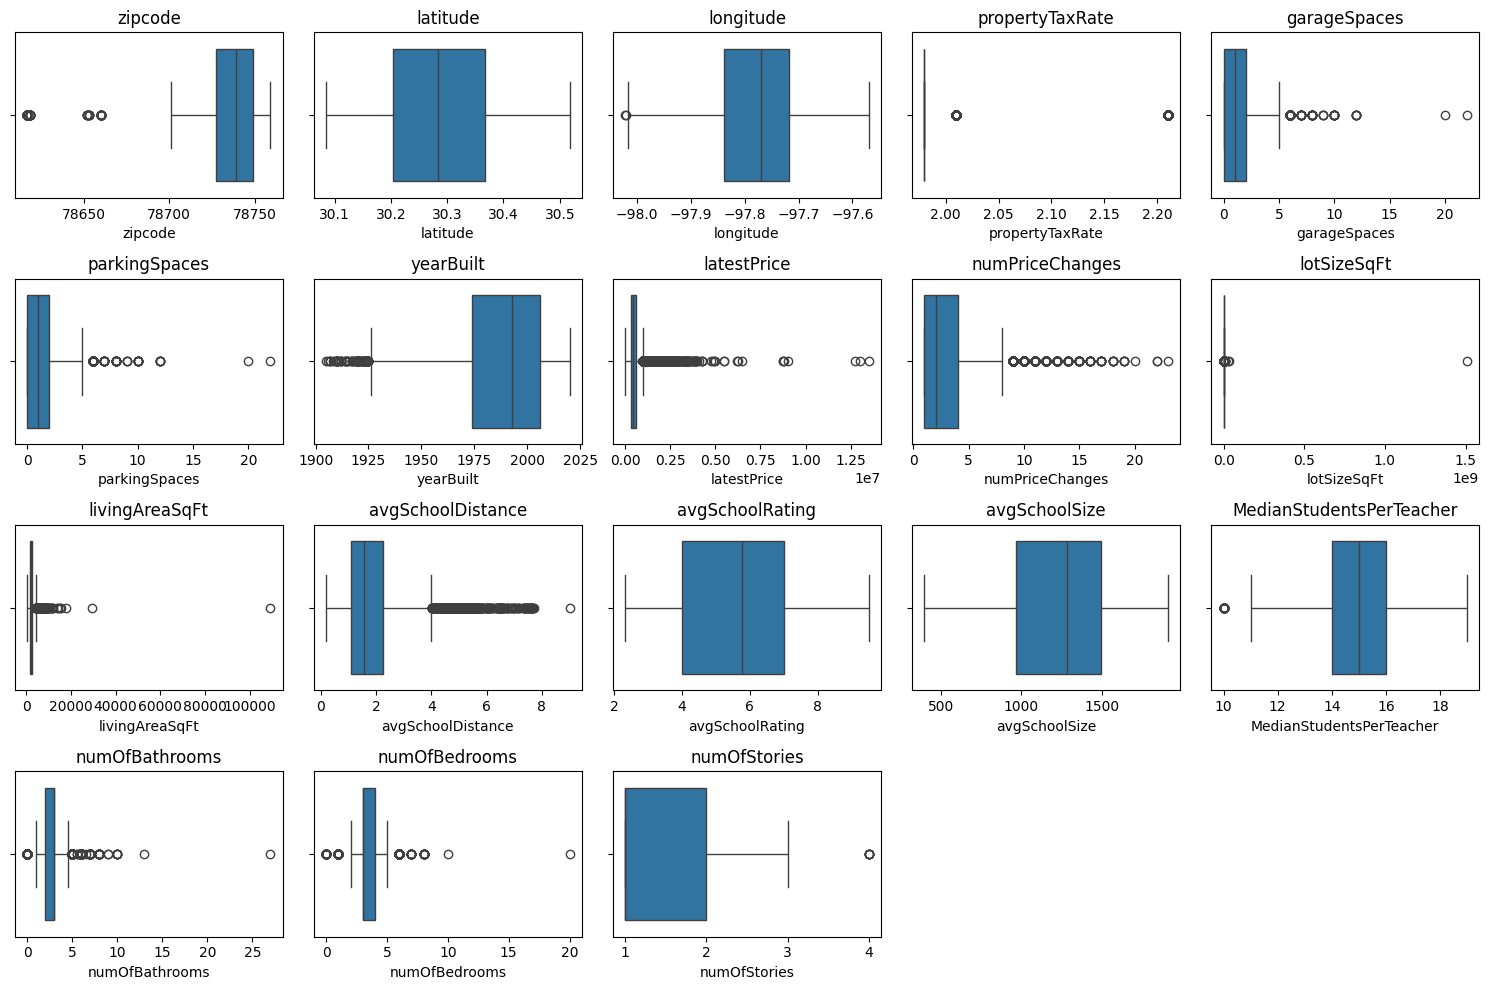

In [ ]:
# Boxplots for key features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_subset.columns, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(x=austin_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()



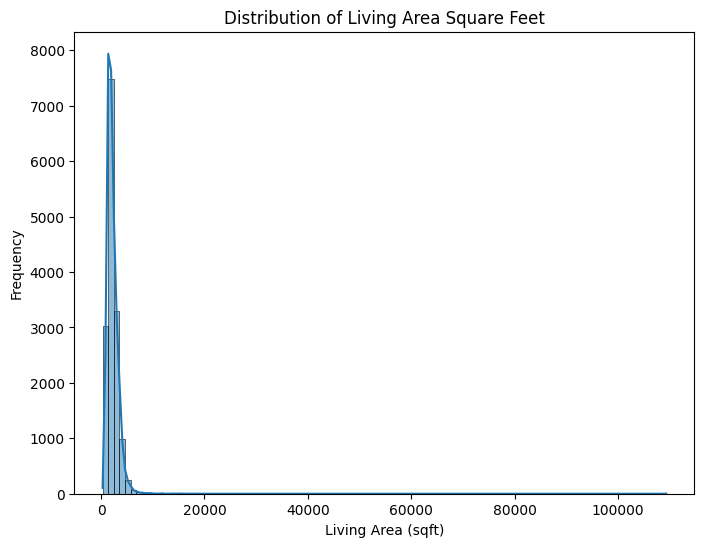

In [ ]:
# Distribution plot for living area square feet
plt.figure(figsize=(8, 6))
sns.histplot(austin_data['livingAreaSqFt'], bins=100, kde=True)
plt.title('Distribution of Living Area Square Feet')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Frequency')
plt.show()



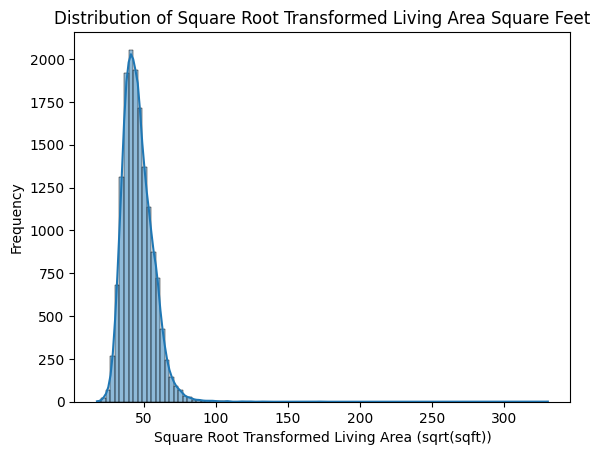

In [ ]:
#due to skew in data, use square root transfomration to see distribution:
sqrt_living_area = np.sqrt(austin_data['livingAreaSqFt'])

sns.histplot(sqrt_living_area, bins=100, kde=True)
plt.title('Distribution of Square Root Transformed Living Area Square Feet')
plt.xlabel('Square Root Transformed Living Area (sqrt(sqft))')
plt.ylabel('Frequency')
plt.show()


Data is still right skewed, but square root transformation allows us to better see that most of the values are distrbibuted on the left end, with outliers on the right end.

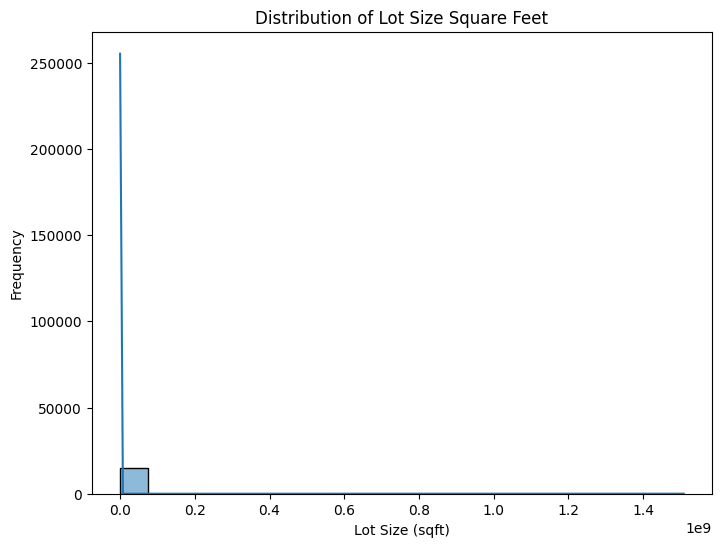

In [ ]:
# Distribution plot for lot size square feet
plt.figure(figsize=(8, 6))
sns.histplot(austin_data['lotSizeSqFt'], bins=20, kde=True)
plt.title('Distribution of Lot Size Square Feet')
plt.xlabel('Lot Size (sqft)')
plt.ylabel('Frequency')
plt.show()

Observation:Heavily right skewed, which makes sense given that the houses with very large square feet will be less common.

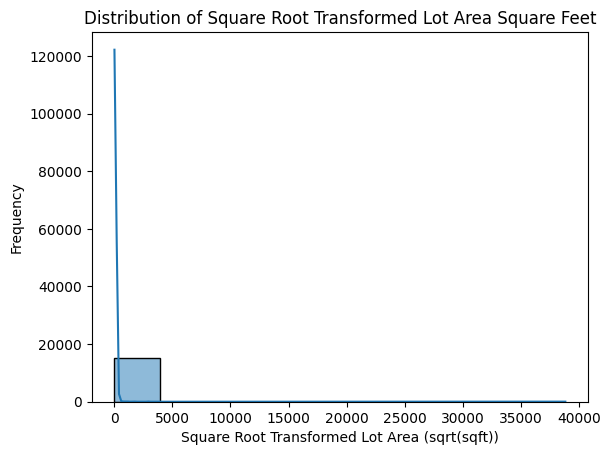

In [ ]:
#due to heavy skew, add square root transformation
sqrt_lot_size= np.sqrt(austin_data['lotSizeSqFt'])

sns.histplot(sqrt_lot_size, bins=10, kde=True)
plt.title('Distribution of Square Root Transformed Lot Area Square Feet')
plt.xlabel('Square Root Transformed Lot Area (sqrt(sqft))')
plt.ylabel('Frequency')
plt.show()

Lot area data is still heavily skewed even with square root transformation. For clustering, this could easily have an impact on centers and means.

In [ ]:
#Given lot area is heavily skewed, and that some of the square feet are not very interpretable, convert to acres and remove outliers

# Calculate IQR
Q1 = austin_data['lotSizeSqFt'].quantile(0.25)
Q3 = austin_data['lotSizeSqFt'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and count outliers
outliers = austin_data[(austin_data['lotSizeSqFt'] < lower_bound) | (austin_data['lotSizeSqFt'] > upper_bound)]
num_outliers = len(outliers)
outlier_perc = (len(outliers)/len(austin_data))*100


In [ ]:
print(min(outliers['lotSizeSqFt']))

17859.6


In [ ]:
print(outlier_perc)

8.674444664161888


getting rid of 8.67% of data is a lot. do further investigation

In [ ]:
#check lots that are greater than 100k
lotgrhundrk = austin_data[austin_data['lotSizeSqFt'] > 100000]
#check lots that are greater than acre
lotgracre = austin_data[austin_data['lotSizeSqFt'] > 43560]

In [ ]:
print(len(lotgrhundrk))

155


In [ ]:
print(len(lotgracre))

507


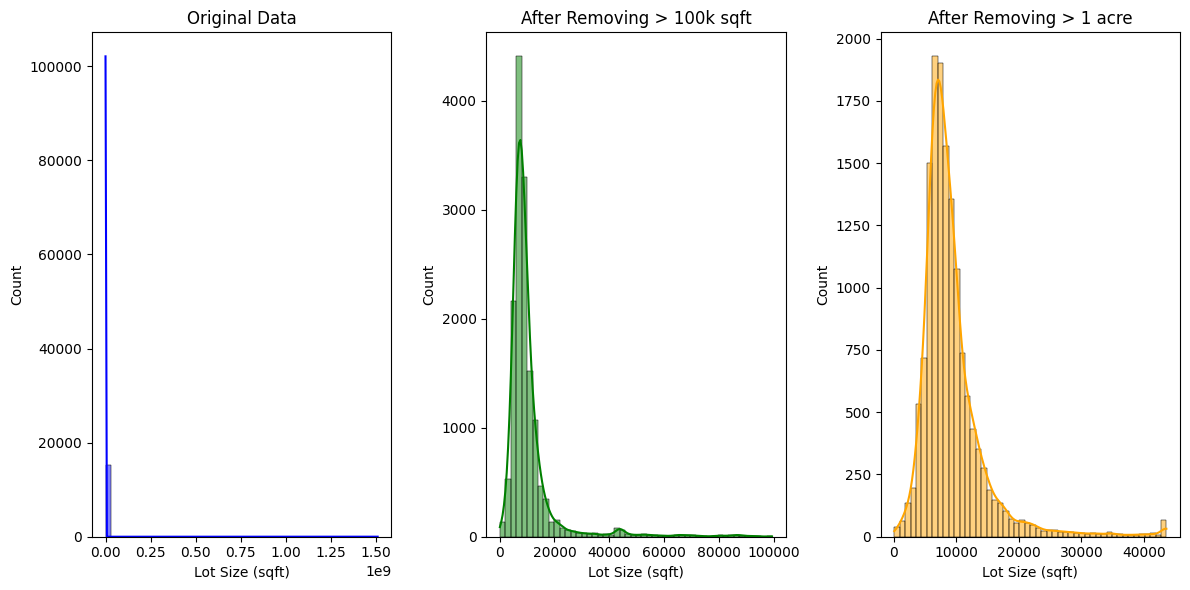

In [ ]:
#create temporary dataframes and check distributions of lot size after removing values greater than 43560 and 100000
austin_temp_hundrk = austin_data.drop(lotgrhundrk.index)
austin_temp_acre = austin_data.drop(lotgracre.index)

# Plot all histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.histplot(austin_data['lotSizeSqFt'], bins=50, kde=True, color='blue')
plt.title('Original Data')
plt.xlabel('Lot Size (sqft)')

plt.subplot(1, 3, 2)
sns.histplot(austin_temp_hundrk['lotSizeSqFt'], bins=50, kde=True, color='green')
plt.title('After Removing > 100k sqft')
plt.xlabel('Lot Size (sqft)')

plt.subplot(1, 3, 3)
sns.histplot(austin_temp_acre['lotSizeSqFt'], bins=50, kde=True, color='orange')
plt.title('After Removing > 1 acre')
plt.xlabel('Lot Size (sqft)')

plt.tight_layout()
plt.show()


Since the middle (Greater than 100k) shares a similar distribution with greater than one acre, and preserves more data, it would make sense to go with the middle option

In [ ]:
#using above approach, modify original austin_data
austin_data = austin_data.drop(lotgrhundrk.index)

In [ ]:
len(austin_data)

15016

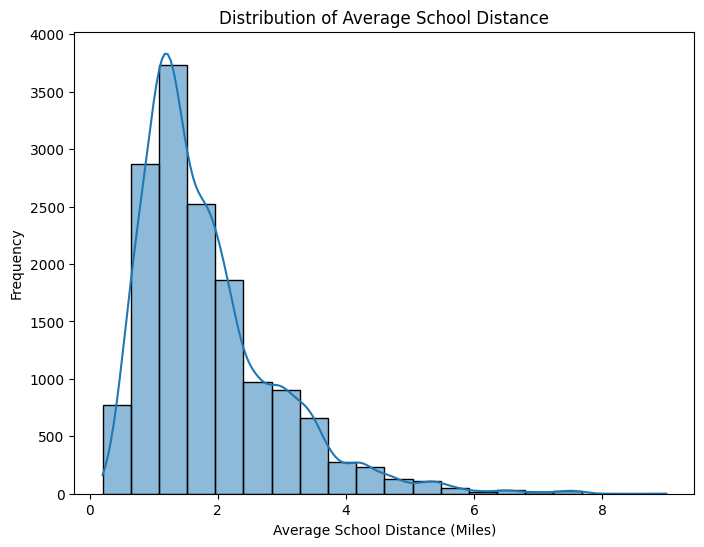

In [ ]:
# Distribution plot for average school distance
plt.figure(figsize=(8, 6))
sns.histplot(austin_data['avgSchoolDistance'], bins=20, kde=True)
plt.title('Distribution of Average School Distance')
plt.xlabel('Average School Distance (Miles)')
plt.ylabel('Frequency')
plt.show()


Note: Data is right skewed with some homes being farther away from schools ona verage and this could likely be in more rural areas of the Austin area

# **3. Selecting Numeric Variables for Analysis**
Since this data will be sued for K-means Clustering, it would be best to use only a subset of numeric house features/attributes that would be important when clustering houses in to distinct house categories. For these reasons, the three variables that are of most interest are: Living Area (Square Feet), Lot Size (Square Feet) and Average School Distance (Miles)

In [ ]:
numeric_vars = ['lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance']
numeric_data = austin_data[numeric_vars].dropna()


In [ ]:
numeric_data.head()

,lotSizeSqFt,livingAreaSqFt,avgSchoolDistance
0,6011.0,2601.0,1.266667
1,6185.0,1768.0,1.400000
2,7840.0,1478.0,1.200000
3,6098.0,1678.0,1.400000
4,6708.0,2132.0,1.133333


# **4.Split in to Train/Test (70-30) Ratio and Scale the data**
In order to use K-means Clustering, the data should be split in to train-test so that means can be compared and the data needs to be scaled.

In [ ]:
# Set seed for reproducibility of results
random_seed = 42
np.random.seed(random_seed)


# Split scaled data into training and test sets
X_train, X_test = train_test_split(numeric_data, test_size=0.3, random_state=random_seed)
# Calculate mean and standard deviation for X_train
X_train_mean = np.mean(X_train, axis=0)
X_train_sd = np.std(X_train, axis=0)

# Scale X_train
X_train_scaled = (X_train - X_train_mean) / X_train_sd

# Scale X_test using parameters from X_train
X_test_scaled = (X_test - X_train_mean) / X_train_sd


# **5. K-Means Solution**
Using training set to extract 2-12 k-means clusters from the data to compare for performance. Generate from 150 random starts, due to local optima problem

In [ ]:
def kmeans_solution(X_train_scaled, k_values):
    results_list = []
    ss = np.sum((X_train_scaled - np.mean(X_train_scaled, axis=0))**2)
    total_ss = np.sum(ss)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=150, random_state=42)
        kmeans.fit(X_train_scaled)

        vaf = (total_ss - kmeans.inertia_) / total_ss

        # Get cluster sizes
        cluster_sizes = pd.Series(kmeans.labels_).value_counts().sort_index()

        results_list.append((k, vaf, kmeans.inertia_, cluster_sizes, kmeans.cluster_centers_))

    return results_list

k_values = range(2, 13)
kmeans_results_std = kmeans_solution(X_train_scaled, k_values)


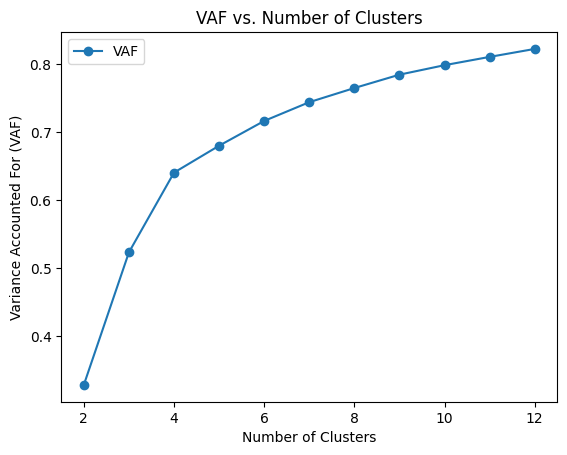

In [ ]:
# Visualize VAF changes with the number of clusters
cluster_size, vaf_list, inertia_list = zip(*[(result[0], result[1], result[2]) for result in kmeans_results_std])
plt.plot(cluster_size, vaf_list, marker='o', label='VAF')
plt.title('VAF vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Variance Accounted For (VAF)')
plt.legend()
plt.show()


In [ ]:
print(vaf_list)

(0.32859779434432135, 0.5234900908185534, 0.6407222713023449, 0.680276773971998, 0.7167068564985816, 0.7443079388709003, 0.76509205061847, 0.7847392193339885, 0.7986920343936473, 0.8108724150887813, 0.8225910580075624)


The variance accounted for is very high for 4 clusters and above


# **6. Scree Test**
Use a scree test to determine the best number of clusters for the K-means solution

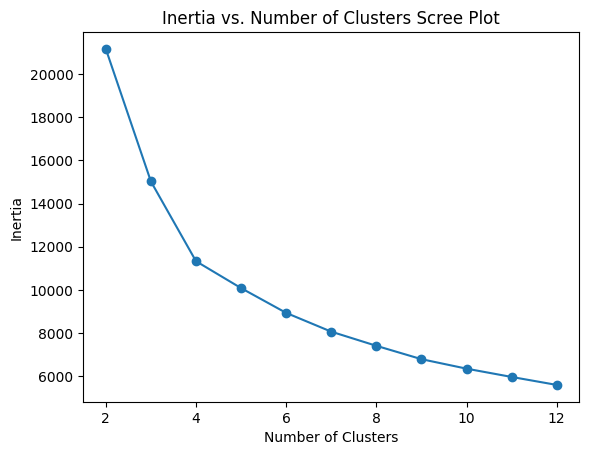

In [ ]:
# Visualize how inertia changes with the number of clusters
plt.plot(cluster_size, inertia_list, marker='o')
plt.title('Inertia vs. Number of Clusters Scree Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


**According to the scree plot above, it is visually clear, 4 clusters is the optimal number of clusters.**

# **7. Best K-Means Solution**

Using 4 k-means clusters, generate the best K-means solution for both train and test and compare the centers and sizes of the clusters

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [ ]:
# Choose the desired K
best_k = 4

# Get the best K-means solution based on VAF
best_kmeans_solution = [result for result in kmeans_results_std if result[0] == best_k][0]

# Extract relevant information for the training set
best_k_train_vaf = best_kmeans_solution[1]
best_k_train_cluster_sizes = best_kmeans_solution[3]
best_k_train_centroids_scaled = best_kmeans_solution[4]
# Inverse transform the scaled centroids to the original scale
X_train_sd_np = X_train_sd.values
X_train_mean_np = X_train_mean.values

# Inverse transform the scaled centroids to the original scale for both training and test
best_k_train_centroids = (best_k_train_centroids_scaled * X_train_sd_np) + X_train_mean_np
k_centroid_tr = pd.DataFrame(best_k_train_centroids, columns=['lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance'])


# Show results
print("Training Set K-Means 4 Cluster Output:")
print(f"VAF (R-square): {best_k_train_vaf}")
print("Cluster Sizes:")
print(best_k_train_cluster_sizes)
print("Cluster Centroids:")
print(k_centroid_tr)



Training Set K-Means 4 Cluster Output:
VAF (R-square): 0.6407222713023449
Cluster Sizes:
0    5943
1    1799
2     359
3    2410
dtype: int64
Cluster Centroids:
   lotSizeSqFt  livingAreaSqFt  avgSchoolDistance
0     7821.981        1623.836              1.328
1     9441.524        2207.056              3.422
2    55539.607        4263.259              3.417
3    11918.048        3234.930              1.605


In [ ]:
# Run K-means on the test data with the centers from the training data as starting point
best_kmeans_test = KMeans(n_clusters=best_k, init=best_k_train_centroids_scaled, n_init=1, random_state=42)
best_kmeans_test.fit(X_test_scaled)

# Extract relevant information for the test set
ss_test = np.sum((X_test_scaled - np.mean(X_test_scaled, axis=0))**2)
total_ss_test = np.sum(ss_test)
best_k_test_vaf = (total_ss_test - best_kmeans_test.inertia_) / total_ss_test
best_k_test_cluster_sizes = pd.Series(best_kmeans_test.labels_).value_counts().sort_index()
best_k_test_centroids_scaled = best_kmeans_test.cluster_centers_

# Inverse transform the scaled centroids to the original scale
best_k_test_centroids = best_k_test_centroids_scaled * X_train_sd_np + X_train_mean_np
k_centroid_test = pd.DataFrame(best_k_test_centroids, columns=['lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance'])

print("Test Set K-Means 4-Cluster Output:")
print(f"VAF (R-square): {best_k_test_vaf}")
print("Cluster Sizes:")
print(best_k_test_cluster_sizes)
print("Cluster Centroids:")
print(k_centroid_test)


Test Set K-Means 4-Cluster Output:
VAF (R-square): 0.6477520951769624
Cluster Sizes:
0    2502
1     864
2     153
3     986
dtype: int64
Cluster Centroids:
   lotSizeSqFt  livingAreaSqFt  avgSchoolDistance
0     7802.022        1616.731              1.310
1     9268.265        2220.233              3.281
2    56861.459        4148.797              3.491
3    11608.171        3214.291              1.571


Observations: The R-squared for both train and test are nearly identical and the means are also nearly identical, which gives confidence in using this 4 cluster k-means clustering approach to cluster Austin area houses.

# **8.Business Insights and Recommendations**


**Insights:**
*   Since the 4 cluster model for Austin, TX area  houses was chosen, above is the table representation of the 4 clusters in terms of its 4 variables and centers to represent important characteristics that consumers will care about in buying houses.
*   The model had an overall Variance accounted for of approximately 64 % and showed very similar means and Variance accounted for when using the test set.
*   The model is very interpretable and is likely representative of Austin housing data
*   **Cautions:**
*   Very large lot size outliers were removed from model, so this missing data could create additional clusters, but given the small % they make of houses, it is likely that they don’t make a big percentage of Austin houses on market.
*   Another caution is this data is in 2021 and the Austin housing market is constantly changing in terms of available houses, Maybe houses available have gotten smaller due to land constraints.
*   Model will possibly need to be updated periodically
**Recommendations:**
*   Using the clusters shown on the right, cluster Austin houses on the market in to the 4 clusters based on the characteristics and means
*   Assign houses to cluster based on overall closeness to the means to find the best fit for a house
*   Because this cluster model segments houses, advertise each cluster of houses differently based on characteristics and determine appropriate pricing to maximize house sales.
*   Ultimately, breaking up the Austin area houses in to clusters based on select important characteristics is an important way to group houses in the Austin area market, and can help to determine each segment of houses and strategies to sell different types of houses.














